# K-Means Exploration
Exploratory notebook for working on birdnet embeddings

### Imports and Setup

In [1]:
import pandas as pd
import os
import numpy as np
from annotation_post_processing import *

In [2]:
embeddingColumns = [str(i) for i in range(420)]
columnNames = ["START", "END"] + embeddingColumns
path = './input/xc_embeddings/'

In [3]:
def generate_embeddings_from_file(path, filename):
    with open(path + filename, 'r') as f:
        data = f.read()
    with open(path + filename, 'w') as f:
        f.write(",".join(data.split("\t")))
    file_df = pd.read_csv(path + filename, names = columnNames)
    file_df["IN FILE"] = filename[:filename.index(".birdnet")] + ".wav"
    return file_df

def generate_embeddings(path):
    df = pd.DataFrame()
    for filename in os.listdir(path):
        try:
            df = pd.concat([df, generate_embeddings_from_file(path, filename)], ignore_index = True)
        except Exception as e:
            print("Something went wrong with: " + filename)
    df["PATH"] = path
    columns = df.columns.tolist()
    columns = columns[-2:] + columns[:-2]
    df = df[columns]
    df = df.sort_values(["IN FILE", "START"], ascending = True)
    df = df.reset_index(drop = True)
    return df

In [4]:
embeddings_df = generate_embeddings(path)
annotations_df = pd.read_csv("xc_annotations.csv")

# removing duplicate annotations
grouped_annotations = annotations_df.groupby(["IN FILE", "OFFSET"])["CONFIDENCE"].max()
annotations_df["MANUAL ID"] = annotations_df.apply(lambda x: x["MANUAL ID"] \
    if grouped_annotations.loc[x["IN FILE"], x["OFFSET"]] == x["CONFIDENCE"] else pd.NA, axis = 1)
annotations_df = annotations_df.dropna(subset = ["MANUAL ID"]).reset_index(drop = True)

In [5]:
manual_df = pd.read_csv("mixed_bird_sample.csv")
manual_df = pd.DataFrame(annotation_chunker(manual_df, 3))
manual_df["MANUAL ID"] = manual_df["MANUAL ID"].apply(lambda x: " ".join(x.split(" ")[:2]))
manual_df

,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID
0,Amazona-aestiva-52744.wav,19.5657,0,0.0,3.0,44100,Amazona aestiva
1,Amazona-aestiva-52744.wav,19.5657,0,3.0,3.0,44100,Amazona aestiva
2,Amazona-aestiva-52744.wav,19.5657,0,6.0,3.0,44100,Amazona aestiva
3,Amazona-aestiva-52744.wav,19.5657,0,9.0,3.0,44100,Amazona aestiva
4,Amazona-aestiva-52744.wav,19.5657,0,12.0,3.0,44100,Amazona aestiva
...,...,...,...,...,...,...,...
976,Zenaida-auriculata-105264.wav,82.9910,0,48.0,3.0,44100,Zenaida auriculata
977,Zenaida-auriculata-105264.wav,82.9910,0,57.0,3.0,44100,Zenaida auriculata
978,Zenaida-auriculata-105264.wav,82.9910,0,60.0,3.0,44100,Zenaida auriculata
979,Zenaida-auriculata-105264.wav,82.9910,0,66.0,3.0,44100,Zenaida auriculata


In [6]:
# Data cleaning to avoid file does not exist
intersection_files = list(set(embeddings_df["IN FILE"].unique()).intersection(set(annotations_df["IN FILE"])))
embeddings_df = embeddings_df[embeddings_df["IN FILE"].isin(intersection_files)]
annotations_df = annotations_df[annotations_df["IN FILE"].isin(intersection_files)]
manual_df = manual_df[manual_df["IN FILE"].isin(intersection_files)]

In [7]:
# Adding manual ids to embeddings
k = 0
def embed_id(x):
    filenames = manual_df["IN FILE"] == x["IN FILE"]
    offsets = np.isclose(manual_df["OFFSET"], x["START"])
    both = filenames & offsets
    if not np.any(both):
        return "No bird"
    return manual_df[both]["MANUAL ID"].iloc[0]

embeddings_df["MANUAL ID"] = embeddings_df.apply(embed_id, axis = 1)
embeddings_df["FILE SPECIES"] = embeddings_df["IN FILE"].apply(lambda x: " ".join(x.split("-")[:2]))

In [8]:
# To change all of the birdnet annotations manual ids to species names
birdnet_species = pd.read_csv("birdnet_species.csv")
birdnet_species.columns = ["SPECIES"]
birdnet_species = birdnet_species.assign(
    SPECIES = birdnet_species["SPECIES"].apply(lambda x: x.split("_")[0]), 
    COMMON = birdnet_species["SPECIES"].apply(lambda x: x.split("_")[1])
)
birdnet_species = birdnet_species.set_index("COMMON").to_dict()["SPECIES"]

annotations_df["MANUAL ID"] = annotations_df["MANUAL ID"].apply(lambda x: birdnet_species[x])

In [9]:
embeddings_df

,IN FILE,PATH,START,END,0,1,2,3,4,5,...,412,413,414,415,416,417,418,419,MANUAL ID,FILE SPECIES
0,Amazona-aestiva-52744.wav,./input/xc_embeddings/,0.0,3.0,0.762929,1.000408,0.432522,0.452946,0.656488,0.737373,...,0.400595,0.883827,1.193243,0.283634,1.542077,0.981433,0.721521,1.163081,Amazona aestiva,Amazona aestiva
1,Amazona-aestiva-52744.wav,./input/xc_embeddings/,3.0,6.0,0.503359,1.043012,1.005796,0.746995,0.574083,0.559189,...,0.300669,0.443966,0.643819,0.377903,1.428960,1.383765,1.037601,0.670695,Amazona aestiva,Amazona aestiva
2,Amazona-aestiva-52744.wav,./input/xc_embeddings/,6.0,9.0,0.524409,1.336747,0.553674,0.334472,0.743905,0.547638,...,0.180524,0.618135,0.340749,0.336239,1.109600,0.923518,0.698893,0.677029,Amazona aestiva,Amazona aestiva
3,Amazona-aestiva-52744.wav,./input/xc_embeddings/,9.0,12.0,0.436074,0.507001,0.915852,0.123285,0.442399,0.537654,...,0.510933,0.126209,0.478544,0.347008,1.033731,0.530908,0.840781,0.675452,Amazona aestiva,Amazona aestiva
4,Amazona-aestiva-52744.wav,./input/xc_embeddings/,12.0,15.0,0.433620,1.535415,0.639228,0.053500,0.584404,0.518180,...,0.233526,0.647830,0.581350,0.101694,0.756994,0.921158,1.034858,0.702051,Amazona aestiva,Amazona aestiva
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,66.0,69.0,0.774719,0.172968,2.005917,0.446872,0.182429,1.709142,...,0.648165,0.610772,0.648035,0.946822,1.422127,0.063739,0.265166,0.462670,Zenaida auriculata,Zenaida auriculata
1270,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,69.0,72.0,0.865834,0.252022,2.261983,0.285904,0.507300,1.582644,...,0.627719,0.182417,0.545958,0.731052,1.079015,0.151970,0.582425,0.567783,Zenaida auriculata,Zenaida auriculata
1271,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,72.0,75.0,0.516543,0.430446,2.036958,0.136788,0.701989,1.653021,...,0.402779,0.267759,0.269648,0.489614,0.008608,0.085612,0.132973,0.294987,No bird,Zenaida auriculata
1272,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,75.0,78.0,0.243208,0.508803,1.145117,0.905772,0.488338,1.596147,...,0.136255,0.410212,0.399387,0.348331,0.103727,0.372924,1.253011,0.634606,No bird,Zenaida auriculata


In [10]:
annotations_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE
0,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,0.0,3.0,48000,Amazona ochrocephala,0.4382
1,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,3.0,3.0,48000,Amazona aestiva,0.9149
2,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,6.0,3.0,48000,Amazona ochrocephala,0.3460
3,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,9.0,3.0,48000,Amazona aestiva,0.8246
4,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,12.0,3.0,48000,Amazona aestiva,0.8547
...,...,...,...,...,...,...,...,...,...
1103,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,66.0,3.0,48000,Zenaida auriculata,0.9999
1104,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,69.0,3.0,48000,Zenaida auriculata,0.9994
1105,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,72.0,3.0,48000,Zenaida auriculata,0.5543
1106,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,75.0,3.0,48000,Columba oenas,0.2265


In [11]:
manual_df

,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID
0,Amazona-aestiva-52744.wav,19.5657,0,0.0,3.0,44100,Amazona aestiva
1,Amazona-aestiva-52744.wav,19.5657,0,3.0,3.0,44100,Amazona aestiva
2,Amazona-aestiva-52744.wav,19.5657,0,6.0,3.0,44100,Amazona aestiva
3,Amazona-aestiva-52744.wav,19.5657,0,9.0,3.0,44100,Amazona aestiva
4,Amazona-aestiva-52744.wav,19.5657,0,12.0,3.0,44100,Amazona aestiva
...,...,...,...,...,...,...,...
976,Zenaida-auriculata-105264.wav,82.9910,0,48.0,3.0,44100,Zenaida auriculata
977,Zenaida-auriculata-105264.wav,82.9910,0,57.0,3.0,44100,Zenaida auriculata
978,Zenaida-auriculata-105264.wav,82.9910,0,60.0,3.0,44100,Zenaida auriculata
979,Zenaida-auriculata-105264.wav,82.9910,0,66.0,3.0,44100,Zenaida auriculata


In [12]:
# Checking to see if same number of files are in all of the dataframes
print(len(embeddings_df["IN FILE"].unique()), len(annotations_df["IN FILE"].unique()), len(manual_df["IN FILE"].unique()))

99 99 99


### K-Means Exploration

In [13]:
from sklearn.cluster import KMeans
import pickle

# Uploading all KMeans models
model_dir = "./KMeansModels/"

model_list:list[KMeans] = []
for model in os.listdir(model_dir):
    with open(model_dir + model, "rb") as f:
        model_list.append(pickle.load(f))

wcss_data = pd.read_csv("kmeans_wcss.csv", names=["WCSS Score"])
wcss_data["i"] = wcss_data.index * 5 + 5
wcss_data

,WCSS Score,i
0,84863.071048,5
1,74156.221513,10
2,66279.401569,15
3,61064.587748,20
4,56551.308363,25
5,51676.033288,30
6,48386.166079,35
7,45939.091929,40
8,43393.969898,45
9,41740.063919,50


<AxesSubplot:xlabel='i', ylabel='WCSS Score'>

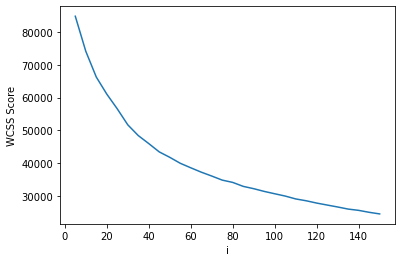

In [14]:
import seaborn as sns
sns.lineplot(data = wcss_data, x = "i", y = "WCSS Score")